Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Trainable params: 16642 || All params: 4402820 || Trainable%: 0.38%


Epoch,Training Loss,Validation Loss
1,0.620500,0.634304
2,0.560400,0.579549
3,0.557800,0.556522


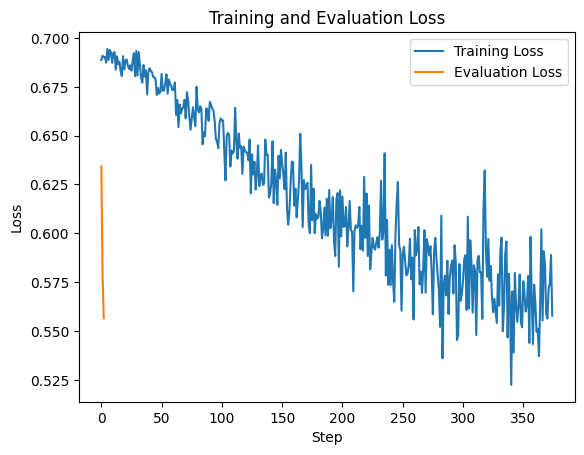

TypeError: HfApi.create_repo() got an unexpected keyword argument 'name'

In [ ]:

# Import necessary libraries
!pip install transformers peft datasets bitsandbytes

import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BitsAndBytesConfig
from datasets import Dataset
from peft import LoraConfig, TaskType, get_peft_model, prepare_model_for_kbit_training
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import EarlyStoppingCallback, DataCollatorWithPadding

# Set seeds for reproducibility
random.seed(42)
torch.manual_seed(42)

# Device settings for both GPU and CPU compatibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import dataset
data = pd.read_csv('IMDB Dataset.csv')

# Stratified train-test split for balanced label distribution
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['sentiment'])

# Convert pandas DataFrames to Hugging Face Datasets
training_set = Dataset.from_pandas(train_data)
test_set = Dataset.from_pandas(test_data)

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
original_model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=2)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["review"], padding="max_length", truncation=True, max_length=512)

# Tokenize datasets
tokenized_training_set = training_set.map(tokenize_function, batched=True)
tokenized_test_set = test_set.map(tokenize_function, batched=True)

# Define the label mapping
label_mapping = {"positive": 1, "negative": 0}
tokenized_training_set = tokenized_training_set.map(lambda examples: {'labels': label_mapping[examples['sentiment']]})
tokenized_test_set = tokenized_test_set.map(lambda examples: {'labels': label_mapping[examples['sentiment']]})

# Training arguments with improved settings
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,  # Increased to ensure better training convergence
    per_device_train_batch_size=16,  # Reduced for memory efficiency
    per_device_eval_batch_size=16,
    warmup_steps=300,  # Lowered for faster warmup
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=3,
    save_strategy="epoch",
    eval_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    gradient_accumulation_steps=2,
    lr_scheduler_type="linear",  # Simplified scheduler for consistency
    learning_rate=3e-5,  # Adjusted for stability
    report_to="tensorboard",
    seed=42,
    fp16=True
)

# Bits and Bytes configuration for quantization
config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.float16  # Changed from `bfloat16` for compatibility
)

# Prepare model for LoRA training
model = prepare_model_for_kbit_training(original_model)

# PEFT configuration for parameter-efficient training
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05
)
qlora_model = get_peft_model(model, peft_config)

# Function to print trainable parameters
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"Trainable params: {trainable_params} || All params: {all_param} || Trainable%: {100 * trainable_params / all_param:.2f}%"
    )

print_trainable_parameters(qlora_model)

# Data collator for padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Custom callback for recording loss values
from transformers import TrainerCallback

class LossRecorderCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.train_losses.append(logs['loss'])
        if 'eval_loss' in logs:
            self.eval_losses.append(logs['eval_loss'])

loss_recorder = LossRecorderCallback()

# Trainer initialization
trainer = Trainer(
    model=qlora_model,
    args=training_args,
    train_dataset=tokenized_training_set,
    eval_dataset=tokenized_test_set,
    data_collator=data_collator,
    callbacks=[loss_recorder]
)

# Train the model
trainer.train()

# Plot training and evaluation loss
plt.plot(loss_recorder.train_losses, label="Training Loss")
plt.plot(loss_recorder.eval_losses, label="Evaluation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss")
plt.legend()
plt.show()

# Evaluate the model
trainer.evaluate()

# Save model locally
save_path = "/content/Project-Blockbuster"
os.makedirs(save_path, exist_ok=True)
qlora_model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)



In [ ]:
# Push model to Hugging Face Hub
from huggingface_hub import HfApi, create_repo

from google.colab import userdata
userdata.get('HF_TOKEN')

model.push_to_hub("jamander/Project-Blockbuster")


README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/17.6M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jamander/Project-Blockbuster/commit/8c853fc9faca3381694022ce67b8f51b3ce2e9eb', commit_message='Upload BertForSequenceClassification', commit_description='', oid='8c853fc9faca3381694022ce67b8f51b3ce2e9eb', pr_url=None, repo_url=RepoUrl('https://huggingface.co/jamander/Project-Blockbuster', endpoint='https://huggingface.co', repo_type='model', repo_id='jamander/Project-Blockbuster'), pr_revision=None, pr_num=None)

In [1]:
from transformers import AutoTokenizer
from huggingface_hub import login
from getpass import getpass

In [2]:
login('HF_TOKEN')

In [3]:
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [4]:
save_path = "/content/Project-Blockbuster-Tokenizer"
tokenizer.save_pretrained(save_path)

('/content/Project-Blockbuster-Tokenizer/tokenizer_config.json',
 '/content/Project-Blockbuster-Tokenizer/special_tokens_map.json',
 '/content/Project-Blockbuster-Tokenizer/vocab.txt',
 '/content/Project-Blockbuster-Tokenizer/added_tokens.json',
 '/content/Project-Blockbuster-Tokenizer/tokenizer.json')

In [5]:
tokenizer.push_to_hub("jamander/Project-Blockbuster")

README.md:   0%|          | 0.00/4.14k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/jamander/Project-Blockbuster/commit/22a81ce0cc0c28dcc214b6e4c3f04e59bb4a4c91', commit_message='Upload tokenizer', commit_description='', oid='22a81ce0cc0c28dcc214b6e4c3f04e59bb4a4c91', pr_url=None, repo_url=RepoUrl('https://huggingface.co/jamander/Project-Blockbuster', endpoint='https://huggingface.co', repo_type='model', repo_id='jamander/Project-Blockbuster'), pr_revision=None, pr_num=None)